<a href="https://colab.research.google.com/github/L-terrestris/L-terrestris.github.io/blob/main/Team5_SystKinematics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#System Kinematics

Team 5



Gilgal Ansah
gjansah@asu.edu

Javon Grimes
jdgrime1@asu.edu

Jonathan Nguyen
jrnguyen@asu.edu

Jacob Sindorf 
jsindorf@asu.edu


# Device Figure

### System Kinematics

![](https://drive.google.com/uc?export=view&id=13gdjIlxjZWm9enL_Ot7w5sUGL7N549lB)

![picture](https://drive.google.com/uc?export=view&id=1MoV_SsdtSmgzAxK13p9E8fM2waOImSVn)

# Paper Model 

The following paper model was designed using the desired lengths as seen in the systems kinematics figure. It takes 4 sarrus linkages, all with four joint arms of equal length, to allow for translational movement in one direction. 

To simplify the kinematics, only one sarrus linkage is considered, on a 2D plane. 

![picture](https://drive.google.com/uc?export=view&id=19D6zLbf_V9X07mIiaIu9BSjJmoZQC_L8)

#Kinematic Model

Code of the kinematic model (see HW step 3)

In [ ]:
!pip install pypoly2tri idealab_tools foldable_robotics pynamics

     |████████████████████████████████| 92kB 4.7MB/s 
     |████████████████████████████████| 1.8MB 16.9MB/s 


In [ ]:
%matplotlib inline

In [ ]:
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
#from pynamics.body import Body
#from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
#from pynamics.particle import Particle
import pynamics.integration
import sympy
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi
#from pynamics.constraint import Constraint
import scipy.optimize
import math as m

In [ ]:
system = System()
pynamics.set_system(__name__,system)

Creates the required lengths of each link and labels them  l0 to l5. The sizes of the links are the same as seen in the paper model and diagram above converted to meters. Visually we left them as inches as it is easier to read. 

In [ ]:
l0 = Constant(0.0254,'l0',system) # 1" ~ 0.0254m  Setting constant link lengths
l1 = Constant(0.0508,'l1',system)
l2 = Constant(0.0254,'l2',system)
l3 = Constant(0.0254,'l3',system)
l4 = Constant(0.0508,'l4',system)
l5 = Constant(0.0254,'l5',system)

Our system will be a sideways sarrus mechanism (4 combined, one modeled here) that acheives translational motion in the x direction. The bottom link of the mechanism, depicted as pNA is what touches the ground and attaches to the newtonian frame. 
Below we describe the angles and their differentiables based off the system kinematics diagram. These are needed to solve the Jacobian and final system kinematics. 

In [ ]:
# Creating dynamic state variables. system argument denotes them as state variables for pynamics system from above
#3bar
qA,qA_d,qA_dd = Differentiable('qA',system) #Angle between N and A
qB,qB_d,qB_dd = Differentiable('qB',system) #from AB
qC,qC_d,qC_dd = Differentiable('qC',system)


#2bar
qD,qD_d,qD_dd = Differentiable('qD',system) #from DE
qE,qE_d,qE_dd = Differentiable('qE',system) #from DE
qF,qF_d,qF_dd = Differentiable('qF',system) #from EF

The following guess the initial values of the mechanism. Here we want to create it in a point of interesting motion, so our guesses are based on the mechanism in a halfway point. That being halfway between either extenstion or contraction. Essentially this means that the two flat plates that translate in the x direction are half way to one another giving us about a 90 degree angle between the top and bottom links. 

In [ ]:
#Create an initial guess for their starting positions; not necessarily accurate, given the constraint that they are
#supposed to be connected with given, constant length
#Guesses are close but not quite exact for the desired configuration to show that it solves correctly
#3bar
initialvalues = {}
initialvalues[qA]=135*pi/180 
# Setting initial angle values. See above for angle positions
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=-45*pi/180  #90 is optimall guess, 45 is off to show it can solve to 90
initialvalues[qB_d]=0*pi/180
initialvalues[qC]=-45*pi/180
initialvalues[qC_d]=0*pi/180

#2bar
initialvalues[qF]=45*pi/180
initialvalues[qF_d]=0*pi/180
initialvalues[qE]=45*pi/180   #90
initialvalues[qE_d]=0*pi/180
initialvalues[qD]=45*pi/180   #90
initialvalues[qD_d]=0*pi/180

In [ ]:
statevariables = system.get_state_variables() #Retrieve state variables in the order they are stored in the system

All references frames needed to define the system. Set the N frame as the newtonian frame that is fixed. We then rotate each frame from the frame prior (seperatley for each side) about the z axis by an amount of q. q relates to the initial angles we guessed. 

In [ ]:
N = Frame('N') # Initializing frames
A = Frame('A')
B = Frame('B')
C = Frame('C')
D = Frame('D')
E = Frame('E')
F = Frame('F')

In [ ]:
system.set_newtonian(N) #Set N frame as the newtonian

In [ ]:
#3bars
A.rotate_fixed_axis_directed(N,[0,0,1],qA,system) # A reference frame rotates about N's ref frame in Z direction by qA amount
B.rotate_fixed_axis_directed(A,[0,0,1],qB,system)
C.rotate_fixed_axis_directed(B,[0,0,1],qC,system)



F.rotate_fixed_axis_directed(N,[0,0,1],qF,system)
E.rotate_fixed_axis_directed(F,[0,0,1],qE,system)
D.rotate_fixed_axis_directed(E,[0,0,1],qD,system)

Here we define the necessary points to create the mechanism. 

We need the bottom link to touch the ground, giving us the two flat plates parralell to the y axis (enforced with constraints). To do this we consider two three bar mechanisms that mirror one another. We had to use two 3 bar mechanisms as the top angles (that allow pC and pD to combine) have to be specified. 
Each 3 bar is based off of pNA, then using distances and the respective x axis of the specified frame, we build to PCtip and PDtip which are the end effectors of the 3 bar mechanisms we need to combine. 

In [ ]:
pNA=0*N.x # pNA (point NA) position is 0 units in the direction of N reference frame's x direction

pAB=pNA+l0*A.x # pAB position is pNA's position plus l0 units in the direction of ref frame A's x direction

pBC = pAB + l1*B.x # pBC position is pAB's position plus l1 units in the direction of ref frame B's x direction

pCtip = pBC + l2*C.x


pNF = 0*N.x 
pFE = pNF + l5*F.x # pEF position is pNF's position plus l5 units in the direction of ref frame F's x direction
pD = pFE + l4*E.x # pD position is pEF's position plus l4 units in the direction of ref frame D's x direction
pDtip = pD + l3*D.x


In [ ]:
#Arbitrary pout that represents the end effector, here it is  pFE. The system moves in one direction
pout = pFE

In [ ]:
points = [pNA,pAB,pBC,pCtip,pDtip,pD,pFE,pNF]

Create list of initial values 

In [ ]:
statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

Create constraints. 

Our system has 6 inputs, which we defined as the q values earlier. We know that our independant values depend on qA, leaving dependant values for qB,qE,qF,qC,qD. With that we have 5 unknowns and will need 5 constraint equations. 

The following vectors are the ones we need to use for constraints. eq_vector represents the distance between pD and pBC, eq_vector2 is used for pBC pAB, and eq_vector3 is used for pD, pFE. 


In [ ]:
#Define the closed loop kinematics of the four bar linkage.
eq_vector = pD-pBC           # horizontal
eq_vector1 = pDtip - pCtip   # merging two points
eq_vector2 = pBC - pAB       # vertical
eq_vector3 = pD - pFE        # vertical


The actual constraint equations (5 total for 5 unknowns) are below

The first constraint makes sure that the two flat plates are parallel to one another. They are defined by the vectors pAB to pBC and pFE to pDE respectively. To make them parallel the dot product must equal the multiplied value of the magnitude. 
The second constraint makes the pBC,pAB vector parallel with the newtonian y axis, constraining the pFE,pDE vector too. 

The third and forth constraints make sure that both end effectors of the 3bar mechanisms combine and stay at the same x value in the newtonian frame

The final constraint keeps pBC and pD on the same newtonian y value so that the mechanism cannot rotate.

These constraints together allow us to acheive translational motion

In [ ]:

eq = [] # eq -> equation

eq.append(((eq_vector2).dot(eq_vector3))-(l1*l4))
eq.append(((eq_vector2).dot(N.y))-(l1))

eq.append((pCtip).dot(N.x))
eq.append((pDtip).dot(N.x))

eq.append((eq_vector).dot(N.y))

eq_d=[(system.derivative(item)) for item in eq]

Here the independant and dependant values are officially defined. We now have the 5 constraint equations to satisfy the 5 unknowns. 

In [ ]:
qi = [qA]
qd = [qB,qC,qD,qE,qF] #the number of items in qd should = the number of constraints above

In [ ]:
constants = system.constant_values.copy() # Recalls link lengths declared near beginning
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)
constants # Stores the names of constants/known values along with their values

{l₀: 0.0254, l₁: 0.0508, l₂: 0.0254, l₃: 0.0254, l₄: 0.0508, l₅: 0.0254, qA: 2
.356194490192345}

In [ ]:
#substitute constants in equation
eq = [item.subs(constants) for item in eq] # substitutes the values from constants into the equation eq

In [ ]:
#convert to numpy array and sum the error
error = (numpy.array(eq)**2).sum()

In [ ]:
#Convert to a function that scipy can use. Sympy has a “labmdify” function that
#evaluates an expression, but scipy needs a slightly different format.
f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

In [ ]:
guess = [initialvalues[item] for item in qd]

In [ ]:
result = scipy.optimize.minimize(function,guess)
#if result.fun>1e-3:
    #raise(Exception("out of tolerance"))

Here the code solved for the desired mechanism (orange) given the initial guesses (blue). We purposely gave a poor initial guess for one angle so that it is easy to visualize that the system solved correctly

In [ ]:
ini = []
for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])

2021-02-24 22:06:07,477 - pynamics.output - INFO - calculating outputs
2021-02-24 22:06:07,479 - pynamics.output - INFO - done calculating outputs


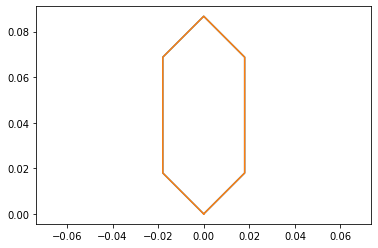

In [ ]:
points = PointsOutput(points, constant_values=system.constant_values)
points.calc(numpy.array([ini0,ini]))
points.plot_time()

In [ ]:
points.calc(numpy.array([ini0,ini]))

2021-02-24 22:06:07,712 - pynamics.output - INFO - calculating outputs
2021-02-24 22:06:07,714 - pynamics.output - INFO - done calculating outputs


array([[[ 0.00000000e+00,  0.00000000e+00],
        [-1.79605122e-02,  1.79605122e-02],
        [-1.79605122e-02,  6.87605122e-02],
        [ 3.46944695e-18,  8.67210245e-02],
        [ 1.73472348e-17,  8.67210245e-02],
        [ 1.79605122e-02,  6.87605122e-02],
        [ 1.79605122e-02,  1.79605122e-02],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00],
        [-1.79605122e-02,  1.79605122e-02],
        [-1.79605122e-02,  6.87605122e-02],
        [ 3.46944695e-18,  8.67210245e-02],
        [ 1.73472348e-17,  8.67210245e-02],
        [ 1.79605122e-02,  6.87605122e-02],
        [ 1.79605122e-02,  1.79605122e-02],
        [ 0.00000000e+00,  0.00000000e+00]]])

 Find Internal Jacobian

 To do so we turn the constraint equations into vectors, giving us two equations for independant and dependant. We then take the derivative of those constraint equation vectors and solve for the internal input/output Jacobian

In [ ]:
eq_d = sympy.Matrix(eq_d)

In [ ]:
qi = sympy.Matrix([qA_d])
qd = sympy.Matrix([qB_d,qC_d,qD_d,qE_d,qF_d])

In [ ]:
AA = eq_d.jacobian(qi)
BB = eq_d.jacobian(qd)

In [ ]:
BB.simplify() #simplify expression so we can actually run jacobian smoothly
BB

⎡     -l₁⋅l₄⋅sin(qA + qB - qE - qF)                 0                      0  
⎢                                                                             
⎢            l₁⋅cos(qA + qB)                        0                      0  
⎢                                                                             
⎢-l₁⋅sin(qA + qB) - l₂⋅sin(qA + qB + qC)  -l₂⋅sin(qA + qB + qC)            0  
⎢                                                                             
⎢                   0                               0            -l₃⋅sin(qD + 
⎢                                                                             
⎣           -l₁⋅cos(qA + qB)                        0                      0  

               l₁⋅l₄⋅sin(qA + qB - qE - qF)                    l₁⋅l₄⋅sin(qA + 
                                                                              
                             0                                              0 
                                                   

In [ ]:
J = -BB.inv()*AA
J  #note, very long and very complex. simplify is necessary to comprehend

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                         ⎛  2                                                
⎢                   l₁⋅l₄⋅⎝l₁ ⋅l₄⋅(-l₃⋅sin(qD + qE + qF) - l₄⋅sin(qE + qF))⋅si
⎢───────────────────────────────────────────────────

We can then simplify the jacobian into a clean looking form that we can utulize for calculations. qd2 is the dependant variables we solve for and subs substitutes the values for us. An example finding vout is shown below that is reused in part 8 of this assignment

In [ ]:
J.simplify()
J

⎡         -1         ⎤
⎢                    ⎥
⎢    -l₀⋅sin(qA)     ⎥
⎢────────────────────⎥
⎢l₂⋅sin(qA + qB + qC)⎥
⎢                    ⎥
⎢-l₀⋅cos(qA)⋅tan(qF) ⎥
⎢────────────────────⎥
⎢l₃⋅sin(qD + qE + qF)⎥
⎢                    ⎥
⎢    -l₀⋅cos(qA)     ⎥
⎢    ────────────    ⎥
⎢     l₅⋅cos(qF)     ⎥
⎢                    ⎥
⎢     l₀⋅cos(qA)     ⎥
⎢     ──────────     ⎥
⎣     l₅⋅cos(qF)     ⎦

In [ ]:
qd2 = J*qi
qd2

⎡          -qA_d          ⎤
⎢                         ⎥
⎢   -l₀⋅qA_d⋅sin(qA)      ⎥
⎢  ────────────────────   ⎥
⎢  l₂⋅sin(qA + qB + qC)   ⎥
⎢                         ⎥
⎢-l₀⋅qA_d⋅cos(qA)⋅tan(qF) ⎥
⎢─────────────────────────⎥
⎢   l₃⋅sin(qD + qE + qF)  ⎥
⎢                         ⎥
⎢    -l₀⋅qA_d⋅cos(qA)     ⎥
⎢    ─────────────────    ⎥
⎢        l₅⋅cos(qF)       ⎥
⎢                         ⎥
⎢     l₀⋅qA_d⋅cos(qA)     ⎥
⎢     ───────────────     ⎥
⎣        l₅⋅cos(qF)       ⎦

In [ ]:
subs = dict([(ii,jj) for ii,jj in zip(qd,qd2)])
subs

⎧                    -l₀⋅qA_d⋅sin(qA)           -l₀⋅qA_d⋅cos(qA)⋅tan(qF)      
⎨qB_d: -qA_d, qC_d: ────────────────────, qD_d: ─────────────────────────, qE_
⎩                   l₂⋅sin(qA + qB + qC)           l₃⋅sin(qD + qE + qF)       

   -l₀⋅qA_d⋅cos(qA)         l₀⋅qA_d⋅cos(qA)⎫
d: ─────────────────, qF_d: ───────────────⎬
       l₅⋅cos(qF)              l₅⋅cos(qF)  ⎭

In [ ]:
pout #pBC end effector

l5*F.x

In [ ]:
vout = pout.time_derivative()
vout

l5*qF_d*F.y

In [ ]:
vout = vout.subs(subs)
vout

l0*qA_d*F.y*cos(qA)/cos(qF)

## Middle of Typical Gait (#4)

As mentioned above, when solving the constraints and creating the mechanism, we initially made it into a position of interest. That position being the midway point between full extension and full compression. That point in the motion is where all the motion occurs as the system occilates between compression and decompression states to generate its peristaltic motion. 

## Plot (#5)

![picture](https://drive.google.com/uc?export=view&id=1GKrT557wQNKp3ZWGv9lyS1ks0-B5QCnt)

## Force Vector Estimates (#6)

>From your biomechanics-based specifications, define one or more force vector estimates (one for each end effector) that the system should be expected to experience. Consider including, based on your research
>
>1. the force of gravity exerted by the mass of a “payload” or the main body of the robot.
>2. the acceleration the system experiences during a typical gait
>3. ground reaction forces measured from biomechanics studies.

Below are some of the main forces we are considering.

- Gravity -> Friction on End-Effector and Rear/Base
 - Need to consider weight of motor and weight of materials
- Spring Force
 - Defined by distance between links and spring constant
- Tension from Motor/String
 - Enough to match or surpass spring force

Average Velocity (m/s) 

0.02 m/s

Fround Reaction Force (N)

1.07×10-1 N

# Force/Torque at Input (#7)

>Calculate the force or torque required at the input to satisfy the end-effector force requirements

Below is the calculation of the force required at the input, based on the sarrus kinematics assignment.


In [ ]:
F_ee = numpy.array([-0.5, 0,0,0,0]).T # Arbitrary force vector on end effector; need to figure out how to use the 5x1 Jacobian
F_in = J.T.dot(F_ee)
F_in

0.500000000000000

In [ ]:
pout

l5*F.x

## Velocity of End Effector (#8)

>Estimate the velocity of the end-effector in this configuration. Using the Jacobian, calculate the speed required by the input(s) to achieve that output motion.

Below are the calculations done to find the velocity of the end effector. See discussion for more details.

In [ ]:
vout

l0*qA_d*F.y*cos(qA)/cos(qF)

In [ ]:
angA = 135*pi/180 #radians
angF = 45*pi/180 #radians
length0 = 0.0254 #meters
v_in = 0.02 # meters/sec
r = 0.0254
w = -v_in/r
v_out = length0 * w * m.cos(angA)/m.cos(angF)
v_out

0.019999999999999997

## Power (#9)

>Finally, using the two estimates about force and speed at the input, compute the required power in this configuration

Power = Force * Velocity 

In [ ]:
power = F_in * v_out
power

0.0100000000000000

## Discussion

1. How many degrees of freedom does your device have? How many motors? If the answer is not the same, what determines the state of the remaining degrees of freedom? How did you arrive at that number?

Our system has one degree of freedom and we will be driving our system with the strength of one motor. The links will be constrained in such a way that the output will translate in the x direction as we use a sarrus linkage mechanism. Our device will eventually have 4 linked sarrus mechanisms to produce peristaltic motion in the x direction. This would consist of offsetting each sarrus at specific times (compression or expansion) and using one driving motor, a system of offset cables can act as a new motor per sarrus. 



2. If your mechanism has more than one degree of freedom, please describe how those multiple degrees of freedom will work togehter to create a locomotory gait or useful motion. What is your plan for synchonizing, especially if passive energy storage?

As previously stated, our system has one degree of freedom, in x direction. As the x distance between links 1 and 4 decreases, the y distance between point A and Ctip/Dtip will increase, thus creating motion. The frictional force with the ground prevents back slip in the link giving one directional motion. When combined with 3 other sarrus mechanisms the device can offset the contraction and extension of each to generate wave like motion called peristaltic motion. Using one input motor, a series of cables can be offset so that they pull on the flat plate of each sarrus mechanism separately, contracting it. A spring could then help extend it. By contracting the first link, then the second, third and fourth, then extending in the same order, it generates walking. 


3. How did you estimate your expected end-effector forces

Our robot kinematics was modeled with bio-inspiration from the common earthworm. Based on previously conducted research on the biomechanics of the earthworm, we used the maximum mass of the worm as a basis of calculating the ground reaction force that our end effector will experience. Ideally, the end effector will experience a force unique to the specific segment, however using the maximum mass provides enough room for errors and overloading of the end effector.



4. How did you estimate your expected end-effector speeds

The equation for the velocity of the end effector was found symbolically through the python simulation above. For the estimated velocity values, we used values determined by the biomechanics assignment for worm speed. Geometric relations for angular speed helped us determine the output velocity given a specific input. 
